In [1]:
import os
import sys
import cv2
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch 
from pykeops.torch import LazyTensor
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
import pickle

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


In [2]:
experiment = "split_20231212"
data = "FWF005"

In [3]:
def open_df(data,experiment=experiment):
    df = pd.read_csv(experiment + "/Automation_out/"+data+"_spots.csv",encoding='cp1252',low_memory=False)
    df = df[3:]
    df = df.astype({
            "ID" : int,
            "TRACK_ID" : int, 
            "POSITION_X" : float,
            "POSITION_Y" : float,
            "POSITION_Z" : float,
            "POSITION_T" : float,
            "FRAME" : int,
            "MIN_INTENSITY_CH1" : float,
            "MAX_INTENSITY_CH1" : float,
            "MEDIAN_INTENSITY_CH1" : float,
            "TOTAL_INTENSITY_CH1" : float,
            "STD_INTENSITY_CH1" : float,
            "CONTRAST_CH1" : float,
            "SNR_CH1" : float
            })
    return df

def get_x_data(df,T,zmin=0.0,zmax=100.0):
    return df[(df["FRAME"]==T) & (df["POSITION_Z"]>=zmin) & (df["POSITION_Z"]<=zmax)]["POSITION_X"].to_numpy()
def get_y_data(df,T,zmin=0.0,zmax=100.0):
    return df[(df["FRAME"]==T) & (df["POSITION_Z"]>=zmin) & (df["POSITION_Z"]<=zmax)]["POSITION_Y"].to_numpy()
def get_snr(df,T,zmin=0.0,zmax=100.0):
    return df[(df["FRAME"]==T) & (df["POSITION_Z"]>=zmin) & (df["POSITION_Z"]<=zmax)]["SNR_CH1"].to_numpy()
def get_intensity(df,T,zmin=0.0,zmax=100.0):
    log_intensity = np.log10(df[(df["FRAME"]==T) & (df["POSITION_Z"]>=zmin) & (df["POSITION_Z"]<=zmax)]["TOTAL_INTENSITY_CH1"].to_numpy())
    log_intensity -= log_intensity.min()
    log_intensity *= 0.9/log_intensity.max()
    log_intensity += 0.09
    return log_intensity

In [4]:
def sample_grid(n, dim=2,dtype=torch.float32,device="cpu"):
    grid_points = torch.linspace(0,1,n,dtype=dtype,device=device)
    grid_points = torch.stack(
        torch.meshgrid((grid_points,) * dim, indexing="ij"), dim=-1
    )
    grid_points = grid_points.reshape(-1, dim)
    return grid_points

def df_to_pos_normalized(df,T=1,zmin=0.0,zmax=100.0):
    x_data = get_x_data(df,T,zmin=zmin,zmax=zmax)
    y_data = get_y_data(df,T,zmin=zmin,zmax=zmax)
    x_data /= max(x_data.max(),y_data.max())
    y_data /= max(x_data.max(),y_data.max())
    return torch.tensor(np.c_[x_data,y_data],dtype=torch.float32)

def pos_grid_to_pixels(pos,grid,eps,intensity=None,scale=1.0):
    N = int(math.sqrt(len(grid)))
    x_j = LazyTensor(pos[None,:,:])
    y_i = LazyTensor(grid[:,None,:])
    K = (-((y_i - x_j)**2).sum(-1)/(2*eps**2)).exp()/(2*math.pi*eps**2)
    if intensity is None:
        grid_val = K.sum(1)/len(pos)
    else: 
        grid_val = K @ intensity
    return grid_val.reshape((N,N)) * scale

def df_to_smooth(data,N=512,eps=0.05,T=1,zmin=0.0,zmax=100.0,N0_prox=1140,N0_dist=1140):
    y_grid = sample_grid(N)
    df_prox = open_df(data + "_Proximal")
    df_dist = open_df(data + "_Distal")
    prox_data = df_to_pos_normalized(df_prox,T=T,zmin=zmin,zmax=zmax)
    dist_data = df_to_pos_normalized(df_dist,T=T,zmin=zmin,zmax=zmax)
    
    intensity_prox = torch.tensor(get_intensity(df_prox,T,zmin=zmin,zmax=zmax),dtype=torch.float32)
    intensity_prox /= intensity_prox.sum()
    intensity_dist = torch.tensor(get_intensity(df_dist,T,zmin=zmin,zmax=zmax),dtype=torch.float32)
    intensity_dist /= intensity_dist.sum()
    
    pixels_prox = pos_grid_to_pixels(prox_data,y_grid,eps,intensity_prox,scale=len(prox_data)/N0_prox)
    pixels_dist = pos_grid_to_pixels(dist_data,y_grid,eps,intensity_dist,scale=len(dist_data)/N0_dist)
    
    return pixels_prox, pixels_dist

In [5]:
def plot_smooth(pixels_prox,pixels_dist,alpha_prox=1.0,alpha_dist=1.0,vmin=0.0,vmax=2.0):
    fig_smooth, ax_smooth = plt.subplots()
    
    # Choose colormap
    cmap_prox_base = pl.cm.Purples
    cmap_dist_base = pl.cm.Greens
    # Get the colormap colors
    cmap_prox = cmap_prox_base(np.arange(cmap_prox_base.N))
    cmap_dist = cmap_dist_base(np.arange(cmap_dist_base.N))
    # Set alpha
    cmap_prox[:,-1] = np.linspace(0, 1, cmap_prox_base.N)
    cmap_dist[:,-1] = np.linspace(0, 1, cmap_dist_base.N)
    # Create new colormap
    cmap_prox = ListedColormap(cmap_prox)
    cmap_dist = ListedColormap(cmap_dist)

    im_prox = ax_smooth.imshow(pixels_prox.numpy().transpose(),origin='lower',cmap=cmap_prox,alpha=alpha_prox,vmin=vmin,vmax=vmax)
    im_dist = ax_smooth.imshow(pixels_dist.numpy().transpose(),origin='lower',cmap=cmap_dist,alpha=alpha_dist,vmin=vmin,vmax=vmax)
    ax_smooth.invert_yaxis()
    ax_smooth.set_aspect("equal")
    
    if alpha_prox>0.0:
        fig_smooth.colorbar(im_prox, ax=ax_smooth)
    if alpha_dist>0.0:
        fig_smooth.colorbar(im_dist, ax=ax_smooth)
    
    return fig_smooth, ax_smooth

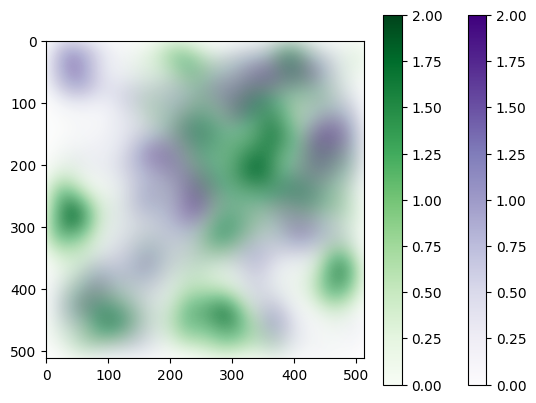

In [6]:
pixels_prox, pixels_dist = df_to_smooth(data,N=512,eps=0.05,T=287,zmin=0.0,zmax=1000.0,N0_prox=1140,N0_dist=1140)
fig, ax = plot_smooth(pixels_prox, pixels_dist)

In [7]:
def make_video(number_of_frames=None,prefix="t_",simu_name="simu",video_name='funny_video',rate=40):
    img_array = []
    current_directory = os.getcwd()
    frame_directory = current_directory+"/"+simu_name+"/frames"
    if number_of_frames is None:
        number_of_frames = len([name for name in os.listdir(frame_directory) if os.path.isfile(os.path.join(frame_directory, name))])
    for count in range(number_of_frames):
        filename = frame_directory+"/"+prefix+str(count)+'.png'
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)
    out = cv2.VideoWriter(simu_name+"/"+video_name+'.avi',cv2.VideoWriter_fourcc(*'DIVX'), rate,size)
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

In [18]:
def save_all(data):
    simu_name = experiment + "_" + data + "_smooth"
    os.mkdir(simu_name)
    os.mkdir(simu_name + "/Proximal")
    os.mkdir(simu_name + "/Distal")
    os.mkdir(simu_name + "/Proximal/frames")
    os.mkdir(simu_name + "/Proximal/data")
    os.mkdir(simu_name + "/Distal/frames")
    os.mkdir(simu_name + "/Distal/data")
    N0_prox = len(get_x_data(open_df(data + "_Proximal"),287,zmin=0.0,zmax=1000.0))
    N0_dist = len(get_x_data(open_df(data + "_Distal"),287,zmin=0.0,zmax=1000.0))
    prox, dist = df_to_smooth(data,T=287,zmin=0.0,zmax=1000.0,N0_prox=N0_prox,N0_dist=N0_dist)
    vmax_prox = prox.max()
    vmax_dist = dist.max()
    for t in tqdm(range(1,288)):
        pixels_prox, pixels_dist = df_to_smooth(data,T=t)
        fig_prox, ax_prox = plot_smooth(pixels_prox, pixels_dist,alpha_dist=0.0,vmax=vmax_prox)
        fig_dist, ax_dist = plot_smooth(pixels_prox, pixels_dist,alpha_prox=0.0,vmax=vmax_dist)
        ax_prox.set_title(f"t={t}")
        ax_dist.set_title(f"t={t}")
        fig_prox.savefig(simu_name + "/Proximal/frames/t_"+str(t-1)+".png")
        fig_dist.savefig(simu_name + "/Distal/frames/t_"+str(t-1)+".png")
        plt.close()
        with open(simu_name + "/Proximal/data/" + f"data_{t}.pkl",'wb') as file:
            pickle.dump(pixels_prox,file)
        with open(simu_name + "/Distal/data/" + f"data_{t}.pkl",'wb') as file:
            pickle.dump(pixels_dist,file)
    make_video(simu_name=simu_name+"/Distal",video_name=simu_name+"_Proximal")
    make_video(simu_name=simu_name+"/Distal",video_name=simu_name+"_Distal")


In [19]:
save_all(data)

  2%|▏         | 7/287 [00:34<23:55,  5.13s/it]